<a href="https://colab.research.google.com/github/artemkavara/Deep-Learning-KPI/blob/main/Lab_2_new.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Лабораторна робота №2

Кавара Артем, КА-81

Виправлений варіант

## Імпорти

In [ ]:
import os
import tarfile
import shutil
import random

In [ ]:
!pip install tensorflow_addons

     |████████████████████████████████| 686kB 6.8MB/s 


In [ ]:
import tensorflow as tf
#import tensorflow_addons as tfa
import numpy as np

In [ ]:
import pandas as pd

In [ ]:
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img

In [ ]:
from tensorflow.keras import Sequential
from tensorflow.keras import layers
from tensorflow.keras import regularizers,constraints

In [ ]:
from tqdm import tqdm

In [ ]:
from sklearn.cluster import KMeans

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
import random

### Завантаження файлів

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
tar_source = "/content/drive/MyDrive/kkanji.tar"
tar_ref = tarfile.TarFile(tar_source, 'r')
tar_ref.extractall('/tmp')
tar_ref.close()

In [ ]:
image_source = "/tmp/kkanji2"
image_classes = os.listdir(image_source)

## Кластеризація

In [ ]:
print(len(image_classes))

3832


Очевидною проблемою для даного датасету є занадто велика кількість класів. Тому для підвищення якості побудованої нейронної мережі необхідно (на початковому етапі) зменшити кількість класів. Для того, щоб розподіл даних був максимально близький до вихідного, необхідно додатково провести кластеризацію.

In [ ]:
def cluster_datagen(classes, base_dir):
  fl_list = []
  img_list = []
  for cl in tqdm(classes):
    dir = base_dir + "/" + cl
    try:
      first_50_images = os.listdir(dir)[:50]
    except IndexError:
      first_50_images = os.listdir(dir)
    for fl in first_50_images:
      file_name = dir+"/"+fl
      img = load_img(file_name, target_size=(64, 64), color_mode ="grayscale")
      img = np.array(img).reshape(1, 64*64)
      img = img/255
      fl_list.append(cl)
      img_list.append(img)
  return img_list, fl_list

In [ ]:
#img_list, fl_list = cluster_datagen(image_classes, image_source)

100%|██████████| 3832/3832 [00:13<00:00, 282.44it/s]


In [ ]:
#img_list = np.array(img_list)
#img_list = img_list.reshape(-1, 4096)
#img_list.shape

(58246, 4096)

In [ ]:
#k = 50
#clusters = KMeans(k, random_state = 40)
#clusters.fit(img_list)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=50, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=40, tol=0.0001, verbose=0)

In [ ]:
#files = {}
#for cluster, file in zip(clusters.labels_, fl_list):
#    if file not in files.keys():
#        files[file] = []
#        files[file].append(cluster)
#    else:
#        files[file].append(cluster)

In [ ]:
#files_cluster = {}
#for file in files.keys():
#  files_cluster[file] = max(set(files[file]), key=files[file].count)

In [ ]:
#files_cluster

In [ ]:
#with open("temp.txt", "w") as f:
#  f.write(str(files))

In [ ]:
#with open("clusters.txt", "w") as f:
#  f.write(str(files_cluster))

In [ ]:
#add clusters.txt to content dir
with open("/content/drive//MyDrive/clusters.txt", "r") as f:
  clusters_final = f.readline()

In [ ]:
clusters_final = eval(clusters_final)

In [ ]:
clusters_final

In [ ]:
os.mkdir("/tmp/new_kkanji")

In [ ]:
for i in range(50):
  os.mkdir(f"/tmp/new_kkanji/{i}")

In [ ]:
for cl in clusters_final.keys():
  source_dir = image_source+"/"+cl
  for file in os.listdir(source_dir):
    shutil.copyfile(source_dir+"/"+file, f"/tmp/new_kkanji/{clusters_final[cl]}/{file}")

### Поділ на тренувальну та валідаційну вибірки

In [ ]:
def generate_train_valid(batch_size, data_dir, label_mode = None, class_names = None):
  train_generator = tf.keras.preprocessing.image_dataset_from_directory(
            data_dir,
            validation_split=0.2,
            subset="training",
            seed=42,
            label_mode = label_mode if not None else 'int',
            image_size=(64, 64),
            batch_size=batch_size,
            color_mode = "grayscale",
            class_names = class_names)

  valid_generator = tf.keras.preprocessing.image_dataset_from_directory(
            data_dir,
            validation_split=0.2,
            subset="validation",
            seed=42,
            image_size=(64, 64),
            batch_size=batch_size,
            label_mode = label_mode if not None else 'int',
            color_mode = "grayscale",
            class_names = class_names)
  return train_generator, valid_generator

In [ ]:
batch_size = 1000

In [ ]:
train_generator, valid_generator = generate_train_valid(batch_size, "/tmp/new_kkanji")

Found 140424 files belonging to 50 classes.
Using 112340 files for training.
Found 140424 files belonging to 50 classes.
Using 28084 files for validation.


## Побудова та навчання базової моделі з єдиним вихiдним шаром softmax.

In [ ]:
num_classes = 50

In [ ]:
sns.set_theme()

In [ ]:
def plot_res(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(acc))

  plt.plot(epochs, acc, label = "Train")
  plt.plot(epochs, val_acc, label = "Validation")
  plt.title('Training and validation accuracy')

  plt.figure()

  plt.plot(epochs, loss, label = "Train")
  plt.plot(epochs, val_loss, label = "Validation")
  plt.title('Training and validation loss')
  plt.legend()

In [ ]:
model_0 = tf.keras.Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(64, 64, 1)),
  layers.Flatten(),
  layers.Dense(num_classes, kernel_initializer='normal', activation='softmax')
])

In [ ]:
model_0.compile(
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [ ]:
with tf.device('/device:GPU:0'):
  history_0 = model_0.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=10
  )

Epoch 1/10


ValueError: ignored

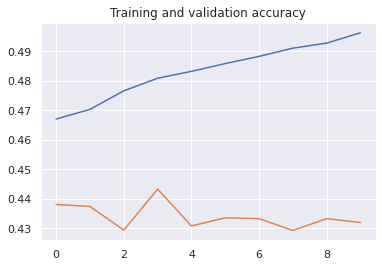

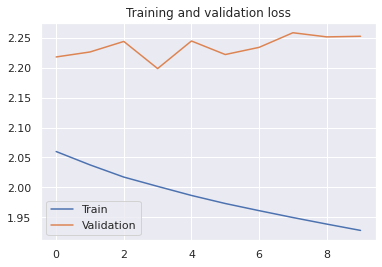

In [ ]:
plot_res(history_0)

## Моделі iз симетричними функцiями активацiї tanh навчити методом ґрадiєнтного спуску, використовуючи iнiцiалiзацiю ваг Глоро.

In [ ]:
model_1 = tf.keras.Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(64, 64, 1)),
  layers.Flatten(),
  layers.Dense(64*64, kernel_initializer="glorot_normal", activation='tanh'),
  layers.Dense(num_classes, kernel_initializer='normal', activation='softmax')
])

In [ ]:
model_1.compile(
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [ ]:
with tf.device('/device:GPU:0'):
  history_1 = model_1.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=10
  )

Epoch 1/10
113/113 [==============================] - 62s 501ms/step - loss: 11.4249 - accuracy: 0.2073 - val_loss: 3.9152 - val_accuracy: 0.3075
Epoch 2/10
113/113 [==============================] - 60s 506ms/step - loss: 3.4425 - accuracy: 0.3832 - val_loss: 3.7881 - val_accuracy: 0.3961
Epoch 3/10
113/113 [==============================] - 61s 509ms/step - loss: 2.9227 - accuracy: 0.4615 - val_loss: 3.2270 - val_accuracy: 0.4318
Epoch 4/10
113/113 [==============================] - 61s 510ms/step - loss: 2.4804 - accuracy: 0.5179 - val_loss: 2.8432 - val_accuracy: 0.4984
Epoch 5/10
113/113 [==============================] - 48s 395ms/step - loss: 2.1204 - accuracy: 0.5681 - val_loss: 2.4190 - val_accuracy: 0.5181
Epoch 6/10
113/113 [==============================] - 51s 429ms/step - loss: 1.8951 - accuracy: 0.6040 - val_loss: 2.7481 - val_accuracy: 0.5087
Epoch 7/10
113/113 [==============================] - 57s 488ms/step - loss: 1.6917 - accuracy: 0.6376 - val_loss: 2.3062 - val_a

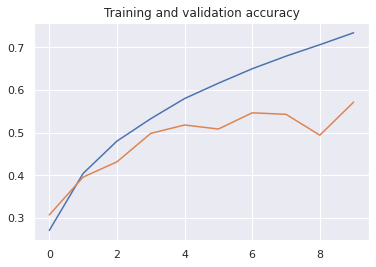

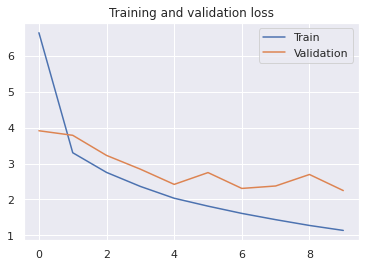

In [ ]:
plot_res(history_1)

## Моделi iз несиметричними функцiями активацiї ReLU навчити методом ґрадiєнтного спуску, використовуючи iнiцiалiзацiю ваг Хе.

In [ ]:
model_2 = tf.keras.Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(64, 64, 1)),
  layers.Flatten(),
  layers.Dense(64*64, kernel_initializer="glorot_normal", activation='relu'),
  layers.Dense(num_classes, kernel_initializer='glorot_normal', activation='softmax')
])

In [ ]:
model_2.compile(
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [ ]:
with tf.device('/device:GPU:0'):
  history_2 = model_2.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=10
  )

Epoch 1/10
113/113 [==============================] - 60s 508ms/step - loss: 5.7927 - accuracy: 0.3004 - val_loss: 1.7916 - val_accuracy: 0.5175
Epoch 2/10
113/113 [==============================] - 57s 491ms/step - loss: 1.6358 - accuracy: 0.5544 - val_loss: 1.5601 - val_accuracy: 0.5805
Epoch 3/10
113/113 [==============================] - 60s 515ms/step - loss: 1.2185 - accuracy: 0.6624 - val_loss: 1.3743 - val_accuracy: 0.6322
Epoch 4/10
113/113 [==============================] - 58s 493ms/step - loss: 0.9301 - accuracy: 0.7375 - val_loss: 1.3889 - val_accuracy: 0.6410
Epoch 5/10
113/113 [==============================] - 58s 494ms/step - loss: 0.7077 - accuracy: 0.7984 - val_loss: 1.3516 - val_accuracy: 0.6642
Epoch 6/10
113/113 [==============================] - 58s 497ms/step - loss: 0.5171 - accuracy: 0.8498 - val_loss: 1.3653 - val_accuracy: 0.6731
Epoch 7/10
113/113 [==============================] - 58s 494ms/step - loss: 0.3655 - accuracy: 0.8957 - val_loss: 1.3401 - val_ac

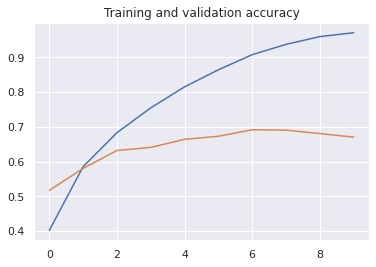

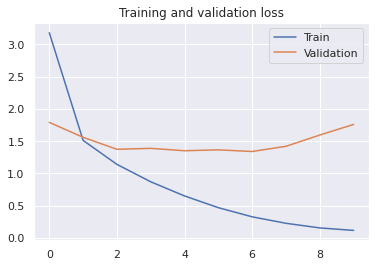

In [ ]:
plot_res(history_2)

## Покращення моделей

### SGD(0.01)

In [ ]:
model_21 = tf.keras.Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(64, 64)),
  layers.Flatten(),
  layers.Dense(64*64, kernel_initializer="glorot_normal", activation='relu'),
  layers.Dense(num_classes, kernel_initializer='glorot_normal', activation='softmax')
])

In [ ]:
model_21.compile(
  optimizer= tf.optimizers.SGD(learning_rate=0.01),  
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [ ]:
with tf.device('/device:GPU:0'):
  history_21 = model_21.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=10
  )

Epoch 1/10
113/113 [==============================] - 45s 374ms/step - loss: 3.5888 - accuracy: 0.1396 - val_loss: 2.9567 - val_accuracy: 0.2855
Epoch 2/10
113/113 [==============================] - 44s 375ms/step - loss: 2.8387 - accuracy: 0.3111 - val_loss: 2.5707 - val_accuracy: 0.3587
Epoch 3/10
113/113 [==============================] - 44s 372ms/step - loss: 2.5042 - accuracy: 0.3813 - val_loss: 2.3706 - val_accuracy: 0.4020
Epoch 4/10
113/113 [==============================] - 44s 373ms/step - loss: 2.3256 - accuracy: 0.4170 - val_loss: 2.2550 - val_accuracy: 0.4256
Epoch 5/10
113/113 [==============================] - 44s 373ms/step - loss: 2.2210 - accuracy: 0.4384 - val_loss: 2.1825 - val_accuracy: 0.4420
Epoch 6/10
113/113 [==============================] - 44s 374ms/step - loss: 2.1481 - accuracy: 0.4525 - val_loss: 2.1340 - val_accuracy: 0.4548
Epoch 7/10
113/113 [==============================] - 44s 372ms/step - loss: 2.0988 - accuracy: 0.4637 - val_loss: 2.0958 - val_ac

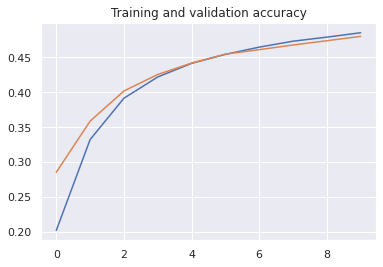

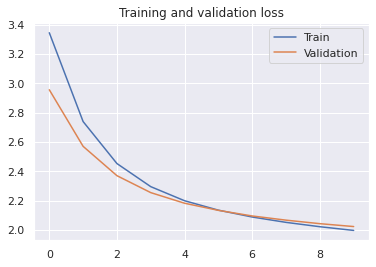

In [ ]:
plot_res(history_21)

### SGD(0.1)

In [ ]:
model_22 = tf.keras.Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(64, 64, 1)),
  layers.Flatten(),
  layers.Dense(64*64, kernel_initializer="glorot_normal", activation='relu'),
  layers.Dense(num_classes, kernel_initializer='glorot_normal', activation='softmax')
])

In [ ]:
model_22.compile(
  optimizer= tf.optimizers.SGD(learning_rate=0.1),  
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [ ]:
with tf.device('/device:GPU:0'):
  history_22 = model_22.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=10
  )

Epoch 1/10
113/113 [==============================] - 45s 374ms/step - loss: 2.8234 - accuracy: 0.2952 - val_loss: 2.1416 - val_accuracy: 0.4271
Epoch 2/10
113/113 [==============================] - 44s 372ms/step - loss: 2.0094 - accuracy: 0.4755 - val_loss: 1.9520 - val_accuracy: 0.4902
Epoch 3/10
113/113 [==============================] - 44s 374ms/step - loss: 1.8522 - accuracy: 0.5174 - val_loss: 1.9786 - val_accuracy: 0.4621
Epoch 4/10
113/113 [==============================] - 46s 387ms/step - loss: 1.7560 - accuracy: 0.5405 - val_loss: 1.7940 - val_accuracy: 0.5297
Epoch 5/10
113/113 [==============================] - 45s 375ms/step - loss: 1.6488 - accuracy: 0.5693 - val_loss: 1.7381 - val_accuracy: 0.5410
Epoch 6/10
113/113 [==============================] - 44s 374ms/step - loss: 1.5806 - accuracy: 0.5864 - val_loss: 1.6864 - val_accuracy: 0.5545
Epoch 7/10
113/113 [==============================] - 45s 375ms/step - loss: 1.5075 - accuracy: 0.6061 - val_loss: 1.6439 - val_ac

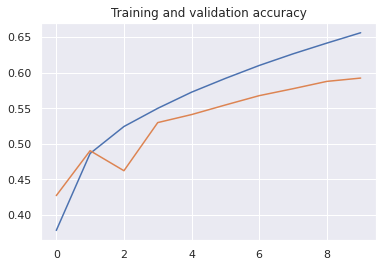

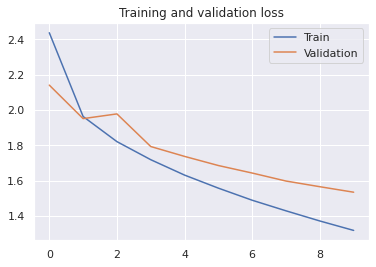

In [ ]:
plot_res(history_22)

### SGD(0.5)

In [ ]:
model_23 = tf.keras.Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(64, 64, 1)),
  layers.Flatten(),
  layers.Dense(64*64, kernel_initializer="glorot_normal", activation='relu'),
  layers.Dense(num_classes, kernel_initializer='glorot_normal', activation='softmax')
])

In [ ]:
model_23.compile(
  optimizer= tf.optimizers.SGD(learning_rate=0.5),  
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [ ]:
with tf.device('/device:GPU:0'):
  history_23 = model_23.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=15
  )

Epoch 1/15
113/113 [==============================] - 45s 374ms/step - loss: 3.2154 - accuracy: 0.2847 - val_loss: 1.9812 - val_accuracy: 0.4692
Epoch 2/15
113/113 [==============================] - 45s 376ms/step - loss: 1.7751 - accuracy: 0.5255 - val_loss: 1.7526 - val_accuracy: 0.5279
Epoch 3/15
113/113 [==============================] - 44s 372ms/step - loss: 1.5156 - accuracy: 0.5922 - val_loss: 1.6274 - val_accuracy: 0.5615
Epoch 4/15
113/113 [==============================] - 44s 373ms/step - loss: 1.3464 - accuracy: 0.6353 - val_loss: 1.5426 - val_accuracy: 0.5778
Epoch 5/15
113/113 [==============================] - 44s 374ms/step - loss: 1.2089 - accuracy: 0.6733 - val_loss: 1.4177 - val_accuracy: 0.6182
Epoch 6/15
113/113 [==============================] - 44s 374ms/step - loss: 1.0909 - accuracy: 0.7024 - val_loss: 1.4179 - val_accuracy: 0.6101
Epoch 7/15
113/113 [==============================] - 45s 375ms/step - loss: 0.9797 - accuracy: 0.7354 - val_loss: 1.3871 - val_ac

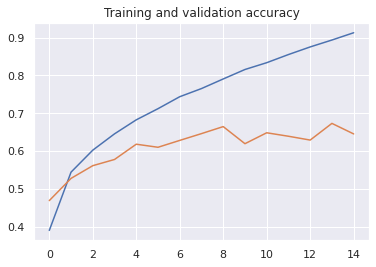

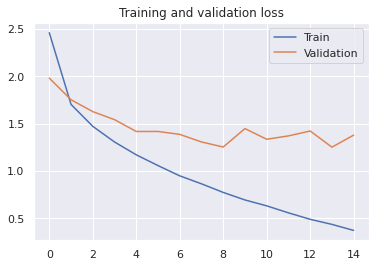

In [ ]:
plot_res(history_23)

## Обрати для нейронiв скритих шарiв рiзнi функцiї активацiї: LeakyReLU, Parametric LeakyReLU, ELU.

Додамо один прихований шар з відповідними функціями активації.

### Leaky RELU

In [ ]:
model_31 = tf.keras.Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(64, 64, 1)),
  layers.Flatten(),
  layers.Dense(64*64, kernel_initializer="glorot_normal", activation=layers.LeakyReLU()),
  layers.Dense(64*64, kernel_initializer="glorot_normal", activation=layers.LeakyReLU()),
  layers.Dense(num_classes, kernel_initializer='glorot_normal', activation='softmax')
])

In [ ]:
model_31.compile(
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [ ]:
with tf.device('/device:GPU:0'):
  history_31 = model_31.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=15
  )

Epoch 1/15
113/113 [==============================] - 65s 551ms/step - loss: 31.4799 - accuracy: 0.1417 - val_loss: 34.0979 - val_accuracy: 0.1087
Epoch 2/15
113/113 [==============================] - 65s 551ms/step - loss: 13.0209 - accuracy: 0.2398 - val_loss: 4.6417 - val_accuracy: 0.3377
Epoch 3/15
113/113 [==============================] - 66s 559ms/step - loss: 11.7064 - accuracy: 0.2660 - val_loss: 14.7583 - val_accuracy: 0.2408
Epoch 4/15
113/113 [==============================] - 66s 556ms/step - loss: 12.2871 - accuracy: 0.2896 - val_loss: 15.2591 - val_accuracy: 0.2072
Epoch 5/15
113/113 [==============================] - 67s 561ms/step - loss: 14.0874 - accuracy: 0.2634 - val_loss: 6.2390 - val_accuracy: 0.3274
Epoch 6/15
113/113 [==============================] - 67s 564ms/step - loss: 9.3370 - accuracy: 0.3279 - val_loss: 11.1528 - val_accuracy: 0.2754
Epoch 7/15
113/113 [==============================] - 68s 571ms/step - loss: 12.6544 - accuracy: 0.2843 - val_loss: 3.916

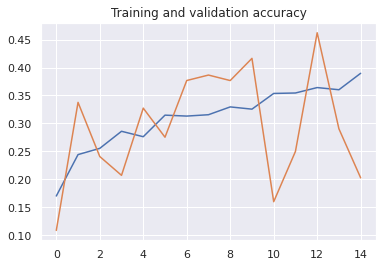

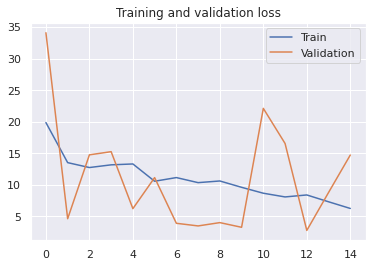

In [ ]:
plot_res(history_31)

### ELU

In [ ]:
model_32 = tf.keras.Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(64, 64, 1)),
  layers.Flatten(),
  layers.Dense(64*64, kernel_initializer="glorot_normal", activation="elu"),
  layers.Dense(64*64, kernel_initializer="glorot_normal", activation="elu"),
  layers.Dense(num_classes, kernel_initializer='glorot_normal', activation='softmax')
])

In [ ]:
model_32.compile(
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [ ]:
with tf.device('/device:GPU:0'):
  history_32 = model_32.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=10
  )

Epoch 1/10
113/113 [==============================] - 68s 570ms/step - loss: 29.5440 - accuracy: 0.1255 - val_loss: 4.7271 - val_accuracy: 0.1949
Epoch 2/10
113/113 [==============================] - 64s 539ms/step - loss: 5.8165 - accuracy: 0.2252 - val_loss: 4.6688 - val_accuracy: 0.2331
Epoch 3/10
113/113 [==============================] - 62s 534ms/step - loss: 4.5117 - accuracy: 0.3060 - val_loss: 3.8868 - val_accuracy: 0.3012
Epoch 4/10
113/113 [==============================] - 63s 537ms/step - loss: 3.5906 - accuracy: 0.3912 - val_loss: 2.6787 - val_accuracy: 0.4444
Epoch 5/10
113/113 [==============================] - 63s 540ms/step - loss: 2.8859 - accuracy: 0.4705 - val_loss: 3.6639 - val_accuracy: 0.4648
Epoch 6/10
113/113 [==============================] - 63s 540ms/step - loss: 2.4819 - accuracy: 0.5382 - val_loss: 3.0083 - val_accuracy: 0.4990
Epoch 7/10
113/113 [==============================] - 63s 544ms/step - loss: 2.0553 - accuracy: 0.5965 - val_loss: 2.3454 - val_a

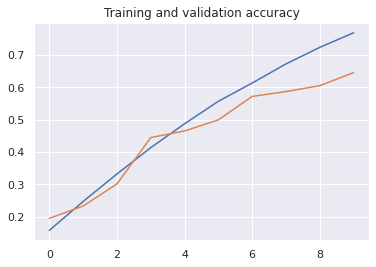

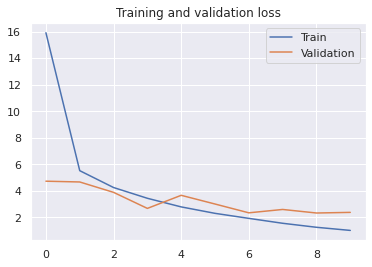

In [ ]:
plot_res(history_32)

### Parametric RELU

In [ ]:
model_33 = tf.keras.Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(64, 64, 1)),
  layers.Flatten(),
  layers.Dense(64*64, kernel_initializer="glorot_normal", activation=layers.PReLU()),
  layers.Dense(64*64, kernel_initializer="glorot_normal", activation=layers.PReLU()),
  layers.Dense(num_classes, kernel_initializer='glorot_normal', activation='softmax')
])

In [ ]:
model_33.compile(
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [ ]:
with tf.device('/device:GPU:0'):
  history_33 = model_33.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=10
  )

Epoch 1/10
113/113 [==============================] - 63s 531ms/step - loss: 7.5786 - accuracy: 0.2617 - val_loss: 1.8337 - val_accuracy: 0.5006
Epoch 2/10
113/113 [==============================] - 62s 529ms/step - loss: 1.7129 - accuracy: 0.5320 - val_loss: 1.4665 - val_accuracy: 0.5990
Epoch 3/10
113/113 [==============================] - 62s 529ms/step - loss: 1.2622 - accuracy: 0.6501 - val_loss: 1.4610 - val_accuracy: 0.6127
Epoch 4/10
113/113 [==============================] - 62s 528ms/step - loss: 0.9413 - accuracy: 0.7342 - val_loss: 1.3753 - val_accuracy: 0.6592
Epoch 5/10
113/113 [==============================] - 62s 531ms/step - loss: 0.6760 - accuracy: 0.8025 - val_loss: 1.4562 - val_accuracy: 0.6803
Epoch 6/10
113/113 [==============================] - 62s 532ms/step - loss: 0.4604 - accuracy: 0.8610 - val_loss: 1.5497 - val_accuracy: 0.6874
Epoch 7/10
113/113 [==============================] - 62s 529ms/step - loss: 0.3084 - accuracy: 0.9070 - val_loss: 1.5487 - val_ac

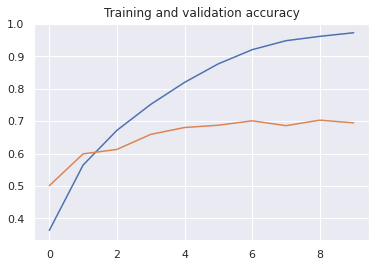

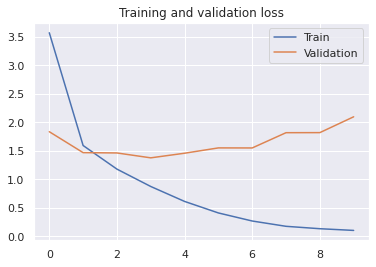

In [ ]:
plot_res(history_33)

## Замiсть методу ґрадiєнтного спуску використати один з адаптивних методiв: прискорений градiєнт Нестерова, Adagrad, Adadelta, Adam

Практика показує, що найбільш ефективним є адаптивний метод Adam

In [ ]:
model_4 = tf.keras.Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(64, 64, 1)),
  layers.Flatten(),
  layers.Dense(64*64, kernel_initializer="glorot_normal", activation=layers.PReLU()),
  layers.Dense(64*64, kernel_initializer="glorot_normal", activation=layers.PReLU()),
  layers.Dense(num_classes, kernel_initializer='glorot_normal', activation='softmax')
])

In [ ]:
model_4.compile(
  optimizer = tf.keras.optimizers.Adam(),
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [ ]:
with tf.device('/device:GPU:0'):
  history_4 = model_4.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=10
  )

Epoch 1/10
113/113 [==============================] - 49s 414ms/step - loss: 2.9123 - accuracy: 0.3540 - val_loss: 1.5071 - val_accuracy: 0.5875
Epoch 2/10
113/113 [==============================] - 48s 408ms/step - loss: 1.3687 - accuracy: 0.6223 - val_loss: 1.3028 - val_accuracy: 0.6427
Epoch 3/10
113/113 [==============================] - 48s 407ms/step - loss: 1.0514 - accuracy: 0.7063 - val_loss: 1.2401 - val_accuracy: 0.6650
Epoch 4/10
113/113 [==============================] - 48s 410ms/step - loss: 0.8102 - accuracy: 0.7700 - val_loss: 1.2054 - val_accuracy: 0.6836
Epoch 5/10
113/113 [==============================] - 48s 408ms/step - loss: 0.5957 - accuracy: 0.8274 - val_loss: 1.2669 - val_accuracy: 0.6864
Epoch 6/10
113/113 [==============================] - 48s 407ms/step - loss: 0.4105 - accuracy: 0.8806 - val_loss: 1.3171 - val_accuracy: 0.6937
Epoch 7/10
113/113 [==============================] - 48s 408ms/step - loss: 0.2630 - accuracy: 0.9240 - val_loss: 1.4171 - val_ac

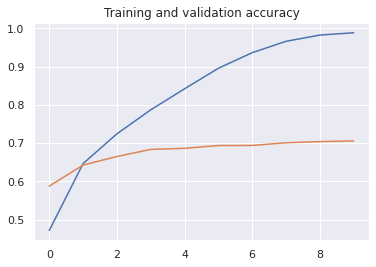

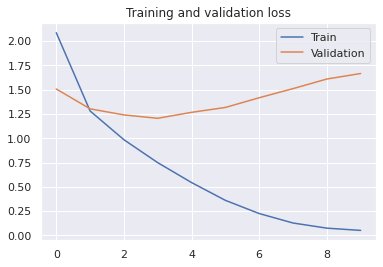

In [ ]:
plot_res(history_4)

## Додати нормалiзацiю за мiнi-батчами

### Adam

In [ ]:
model_5 = tf.keras.Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(64, 64, 1)),
  layers.Flatten(),
  layers.Dense(64*64, kernel_initializer="glorot_normal", activation=layers.PReLU()),
  layers.BatchNormalization(),
  layers.Dense(64*64, kernel_initializer="glorot_normal", activation=layers.PReLU()),
  layers.Dense(num_classes, kernel_initializer='glorot_normal', activation='softmax')
])

In [ ]:
model_5.compile(
  optimizer = tf.keras.optimizers.Adam(),
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [ ]:
with tf.device('/device:GPU:0'):
  history_5 = model_5.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=10
  )

Epoch 1/10
113/113 [==============================] - 49s 409ms/step - loss: 2.5098 - accuracy: 0.4549 - val_loss: 1.5525 - val_accuracy: 0.5863
Epoch 2/10
113/113 [==============================] - 48s 407ms/step - loss: 1.0700 - accuracy: 0.7035 - val_loss: 1.3667 - val_accuracy: 0.6400
Epoch 3/10
113/113 [==============================] - 48s 409ms/step - loss: 0.6777 - accuracy: 0.8057 - val_loss: 1.4232 - val_accuracy: 0.6508
Epoch 4/10
113/113 [==============================] - 48s 406ms/step - loss: 0.3884 - accuracy: 0.8874 - val_loss: 1.5379 - val_accuracy: 0.6612
Epoch 5/10
113/113 [==============================] - 48s 409ms/step - loss: 0.2056 - accuracy: 0.9398 - val_loss: 1.7731 - val_accuracy: 0.6617
Epoch 6/10
113/113 [==============================] - 48s 409ms/step - loss: 0.1232 - accuracy: 0.9650 - val_loss: 1.6756 - val_accuracy: 0.6822
Epoch 7/10
113/113 [==============================] - 48s 409ms/step - loss: 0.1021 - accuracy: 0.9711 - val_loss: 1.8748 - val_ac

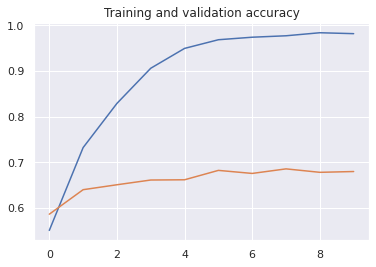

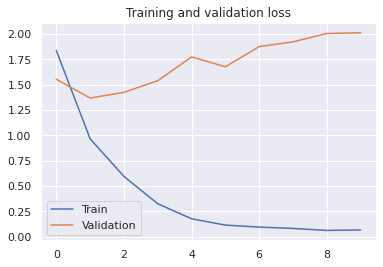

In [ ]:
plot_res(history_5)

### SGD

In [ ]:
model_51 = tf.keras.Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(64, 64, 1)),
  layers.Flatten(),
  layers.Dense(64*64, kernel_initializer="glorot_normal", activation=layers.PReLU()),
  layers.BatchNormalization(),
  layers.Dense(64*64, kernel_initializer="glorot_normal", activation=layers.PReLU()),
  layers.BatchNormalization(),
  layers.Dense(num_classes, kernel_initializer='glorot_normal', activation='softmax')
])

In [ ]:
model_51.compile(
  optimizer = tf.keras.optimizers.SGD(learning_rate=0.25),
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [ ]:
with tf.device('/device:GPU:0'):
  history_51 = model_51.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=10
  )

Epoch 1/10
113/113 [==============================] - 49s 409ms/step - loss: 2.6000 - accuracy: 0.4411 - val_loss: 2.5314 - val_accuracy: 0.3779
Epoch 2/10
113/113 [==============================] - 48s 406ms/step - loss: 0.8854 - accuracy: 0.7566 - val_loss: 1.9647 - val_accuracy: 0.4792
Epoch 3/10
113/113 [==============================] - 48s 410ms/step - loss: 0.4155 - accuracy: 0.8933 - val_loss: 1.5447 - val_accuracy: 0.5841
Epoch 4/10
113/113 [==============================] - 48s 407ms/step - loss: 0.1354 - accuracy: 0.9783 - val_loss: 1.2408 - val_accuracy: 0.6760
Epoch 5/10
113/113 [==============================] - 48s 409ms/step - loss: 0.0351 - accuracy: 0.9990 - val_loss: 1.2193 - val_accuracy: 0.6948
Epoch 6/10
113/113 [==============================] - 48s 410ms/step - loss: 0.0162 - accuracy: 0.9998 - val_loss: 1.2515 - val_accuracy: 0.6997
Epoch 7/10
113/113 [==============================] - 48s 408ms/step - loss: 0.0112 - accuracy: 0.9998 - val_loss: 1.2749 - val_ac

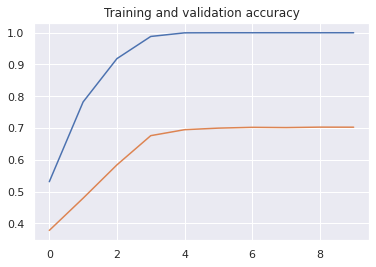

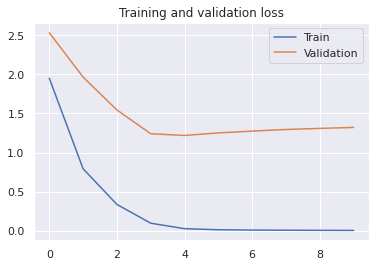

In [ ]:
plot_res(history_51)

## Додати до моделей один/ декiлька шарiв дропауту. Пiдiбрати значення $p$ - iмовiрностi вiдключення нейронiв.

### Один шар

In [ ]:
model_6 = tf.keras.Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(64, 64, 1)),
  layers.Flatten(),
  layers.Dense(64*64, kernel_initializer="glorot_normal", activation=layers.PReLU()),
  layers.BatchNormalization(),
  layers.Dropout(0.1),
  layers.Dense(64*64, kernel_initializer="glorot_normal", activation=layers.PReLU()),
  layers.BatchNormalization(),
  layers.Dense(num_classes, kernel_initializer='glorot_normal', activation='softmax')
])

In [ ]:
model_6.compile(
  optimizer = tf.keras.optimizers.SGD(learning_rate=0.1),
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [ ]:
with tf.device('/device:GPU:0'):
  history_6 = model_6.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=10
  )

Epoch 1/10
113/113 [==============================] - 49s 408ms/step - loss: 2.3219 - accuracy: 0.4337 - val_loss: 2.5662 - val_accuracy: 0.4281
Epoch 2/10
113/113 [==============================] - 48s 408ms/step - loss: 1.0830 - accuracy: 0.7063 - val_loss: 1.9050 - val_accuracy: 0.5136
Epoch 3/10
113/113 [==============================] - 48s 409ms/step - loss: 0.7105 - accuracy: 0.8125 - val_loss: 1.5269 - val_accuracy: 0.5939
Epoch 4/10
113/113 [==============================] - 48s 407ms/step - loss: 0.4641 - accuracy: 0.8912 - val_loss: 1.3117 - val_accuracy: 0.6502
Epoch 5/10
113/113 [==============================] - 48s 408ms/step - loss: 0.2994 - accuracy: 0.9418 - val_loss: 1.2698 - val_accuracy: 0.6670
Epoch 6/10
113/113 [==============================] - 48s 408ms/step - loss: 0.1822 - accuracy: 0.9755 - val_loss: 1.2931 - val_accuracy: 0.6683
Epoch 7/10
113/113 [==============================] - 48s 408ms/step - loss: 0.1175 - accuracy: 0.9897 - val_loss: 1.2827 - val_ac

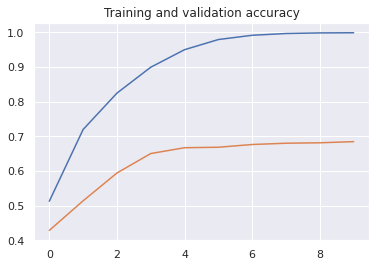

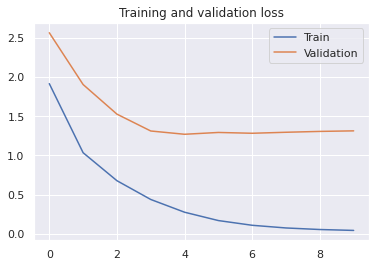

In [ ]:
plot_res(history_6)

### Декілька шарів


In [ ]:
model_61 = tf.keras.Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(64, 64, 1)),
  layers.Flatten(),
  layers.Dense(64*64, kernel_initializer="glorot_normal", activation="relu"),
  layers.BatchNormalization(),
  layers.Dropout(0.01),
  layers.Dense(64*64, kernel_initializer="glorot_normal", activation="relu"),
  layers.BatchNormalization(),
  layers.Dropout(0.01),
  layers.Dense(num_classes, kernel_initializer='glorot_normal', activation='softmax')
])

In [ ]:
model_61.compile(
  optimizer = tf.keras.optimizers.SGD(learning_rate=0.05),
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [ ]:
with tf.device('/device:GPU:0'):
  history_61 = model_61.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=10
  )

Epoch 1/10
113/113 [==============================] - 49s 406ms/step - loss: 2.3867 - accuracy: 0.4106 - val_loss: 2.6636 - val_accuracy: 0.4294
Epoch 2/10
113/113 [==============================] - 48s 406ms/step - loss: 1.1908 - accuracy: 0.6852 - val_loss: 1.9327 - val_accuracy: 0.5398
Epoch 3/10
113/113 [==============================] - 48s 406ms/step - loss: 0.8299 - accuracy: 0.7918 - val_loss: 1.5103 - val_accuracy: 0.6081
Epoch 4/10
113/113 [==============================] - 48s 404ms/step - loss: 0.5921 - accuracy: 0.8663 - val_loss: 1.3693 - val_accuracy: 0.6335
Epoch 5/10
113/113 [==============================] - 48s 404ms/step - loss: 0.4235 - accuracy: 0.9203 - val_loss: 1.3349 - val_accuracy: 0.6413
Epoch 6/10
113/113 [==============================] - 48s 406ms/step - loss: 0.2997 - accuracy: 0.9585 - val_loss: 1.3176 - val_accuracy: 0.6493
Epoch 7/10
113/113 [==============================] - 48s 410ms/step - loss: 0.2116 - accuracy: 0.9808 - val_loss: 1.3176 - val_ac

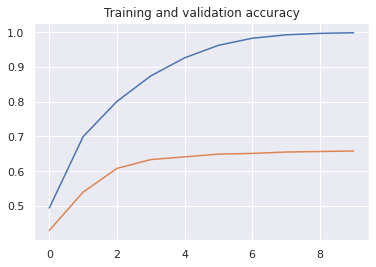

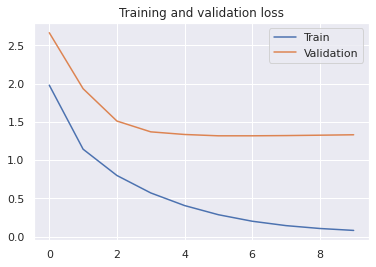

In [ ]:
plot_res(history_61)

## Декілька прихованих шарів

### Різні функції активації

In [ ]:
model_71 = tf.keras.Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(64, 64, 1)),
  layers.Flatten(),
  layers.Dense(64*64, kernel_initializer="glorot_normal", activation="relu"),
  layers.BatchNormalization(),
  layers.Dense(64*64, kernel_initializer="glorot_normal", activation="tanh"),
  layers.Dense(64*64, kernel_initializer="glorot_normal", activation="elu"),
  layers.BatchNormalization(),
  layers.Dense(num_classes, kernel_initializer='glorot_normal', activation='softmax')
])

In [ ]:
model_71.compile(
  optimizer = tf.keras.optimizers.SGD(learning_rate=0.01),
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [ ]:
with tf.device('/device:GPU:0'):
  history_71 = model_71.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=10
  )

Epoch 1/10
113/113 [==============================] - 51s 427ms/step - loss: 2.8318 - accuracy: 0.3113 - val_loss: 2.5696 - val_accuracy: 0.4369
Epoch 2/10
113/113 [==============================] - 50s 428ms/step - loss: 1.8304 - accuracy: 0.5237 - val_loss: 1.9990 - val_accuracy: 0.5036
Epoch 3/10
113/113 [==============================] - 50s 425ms/step - loss: 1.5642 - accuracy: 0.5897 - val_loss: 1.7729 - val_accuracy: 0.5402
Epoch 4/10
113/113 [==============================] - 50s 422ms/step - loss: 1.3834 - accuracy: 0.6366 - val_loss: 1.6633 - val_accuracy: 0.5627
Epoch 5/10
113/113 [==============================] - 50s 424ms/step - loss: 1.2384 - accuracy: 0.6756 - val_loss: 1.5968 - val_accuracy: 0.5788
Epoch 6/10
113/113 [==============================] - 50s 420ms/step - loss: 1.1146 - accuracy: 0.7111 - val_loss: 1.5535 - val_accuracy: 0.5919
Epoch 7/10
113/113 [==============================] - 50s 422ms/step - loss: 1.0091 - accuracy: 0.7417 - val_loss: 1.5200 - val_ac

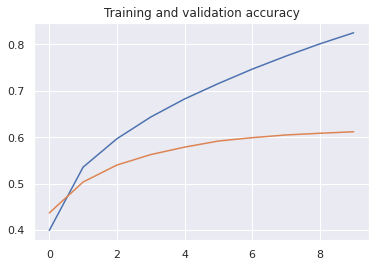

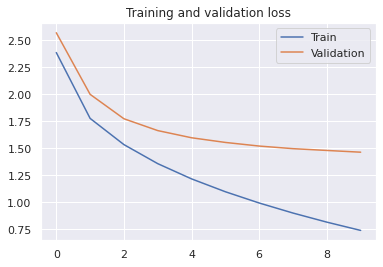

In [ ]:
plot_res(history_71)

### Однакові функції активації

In [ ]:
model_72 = tf.keras.Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(64, 64, 1)),
  layers.Flatten(),
  layers.Dense(64*64, kernel_initializer="glorot_normal", activation="relu"),
  layers.BatchNormalization(),
  layers.Dense(64*64, kernel_initializer="glorot_normal", activation="elu"),
  layers.BatchNormalization(),
  layers.Dense(64*64, kernel_initializer="glorot_normal", activation="relu"),
  layers.BatchNormalization(),
  layers.Dense(num_classes, kernel_initializer='glorot_normal', activation='softmax')
])

In [ ]:
model_72.compile(
  optimizer = tf.keras.optimizers.Adam(learning_rate=0.005),
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [ ]:
with tf.device('/device:GPU:0'):
  history_72 = model_72.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=10
  )

Epoch 1/10
113/113 [==============================] - 51s 425ms/step - loss: 5.7094 - accuracy: 0.2723 - val_loss: 2.1398 - val_accuracy: 0.4566
Epoch 2/10
113/113 [==============================] - 50s 426ms/step - loss: 1.6173 - accuracy: 0.5566 - val_loss: 1.5909 - val_accuracy: 0.5704
Epoch 3/10
113/113 [==============================] - 50s 425ms/step - loss: 1.2641 - accuracy: 0.6497 - val_loss: 1.4277 - val_accuracy: 0.6109
Epoch 4/10
113/113 [==============================] - 50s 422ms/step - loss: 1.0682 - accuracy: 0.7000 - val_loss: 1.4406 - val_accuracy: 0.6259
Epoch 5/10
113/113 [==============================] - 51s 432ms/step - loss: 0.8180 - accuracy: 0.7666 - val_loss: 1.4592 - val_accuracy: 0.6303
Epoch 6/10
113/113 [==============================] - 50s 422ms/step - loss: 0.6807 - accuracy: 0.7993 - val_loss: 1.5269 - val_accuracy: 0.6487
Epoch 7/10
113/113 [==============================] - 50s 420ms/step - loss: 0.4549 - accuracy: 0.8606 - val_loss: 1.6464 - val_ac

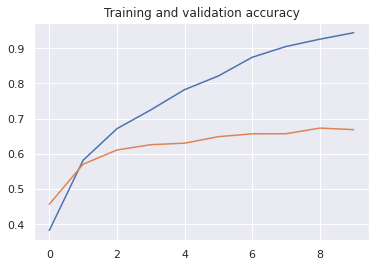

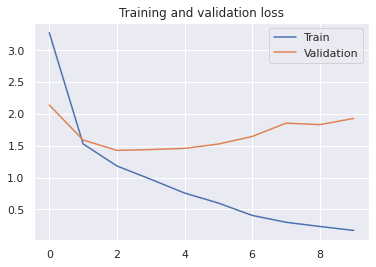

In [ ]:
plot_res(history_72)

## Рання зупинка навчання

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

In [ ]:
model_8_72 = tf.keras.Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(64, 64, 1)),
  layers.Flatten(),
  layers.Dense(64*64, kernel_initializer="glorot_normal", activation="relu"),
  layers.BatchNormalization(),
  layers.Dense(64*64, kernel_initializer="glorot_normal", activation=layers.LeakyReLU()),
  layers.BatchNormalization(),
  layers.Dense(64*64, kernel_initializer="glorot_normal", activation="relu"),
  layers.BatchNormalization(),
  layers.Dense(num_classes, kernel_initializer='glorot_normal', activation='softmax')
])

In [ ]:
model_8_72.compile(
  optimizer = tf.keras.optimizers.Adam(),
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [ ]:
with tf.device('/device:GPU:0'):
  history_8_72 = model_8_72.fit(
    train_generator,
    validation_data=valid_generator,
    epochs = 20,
    callbacks=[callback],
  )

Epoch 1/20
113/113 [==============================] - 71s 597ms/step - loss: 2.8794 - accuracy: 0.4280 - val_loss: 1.7411 - val_accuracy: 0.5263
Epoch 2/20
113/113 [==============================] - 71s 599ms/step - loss: 1.2509 - accuracy: 0.6531 - val_loss: 1.3819 - val_accuracy: 0.6190
Epoch 3/20
113/113 [==============================] - 71s 594ms/step - loss: 0.9232 - accuracy: 0.7380 - val_loss: 1.5053 - val_accuracy: 0.6170
Epoch 4/20
113/113 [==============================] - 71s 599ms/step - loss: 0.7221 - accuracy: 0.7884 - val_loss: 1.6065 - val_accuracy: 0.6311
Epoch 5/20
113/113 [==============================] - 71s 598ms/step - loss: 0.5429 - accuracy: 0.8364 - val_loss: 1.6486 - val_accuracy: 0.6459
Epoch 6/20
113/113 [==============================] - 67s 560ms/step - loss: 0.3895 - accuracy: 0.8782 - val_loss: 1.9560 - val_accuracy: 0.6331
Epoch 7/20
113/113 [==============================] - 66s 565ms/step - loss: 0.2881 - accuracy: 0.9074 - val_loss: 2.0640 - val_ac

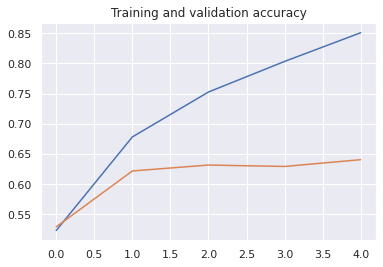

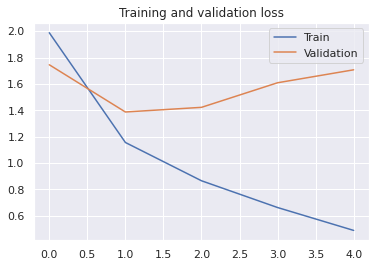

In [ ]:
plot_res(history_8_72)

### Рання зупинка навчання і дропаут

In [ ]:
model_8_1 = tf.keras.Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(64, 64, 1)),
  layers.Flatten(),
  layers.Dense(64*64, kernel_initializer="glorot_normal", activation="tanh"),
  layers.BatchNormalization(),
  layers.Dense(64*64, kernel_initializer="glorot_normal", activation=layers.PReLU()),
  layers.Dropout(0.1),
  layers.Dense(64*64, kernel_initializer="glorot_normal", activation="relu"),
  layers.BatchNormalization(),
  layers.Dense(num_classes, kernel_initializer='glorot_normal', activation='softmax')
])

In [ ]:
model_8_1.compile(
  optimizer = tf.keras.optimizers.Adam(0.0005),
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [ ]:
with tf.device('/device:GPU:0'):
  history_8_1 = model_8_1.fit(
    train_generator,
    validation_data=valid_generator,
    epochs = 20,
    callbacks=[callback],
  )

Epoch 1/20
113/113 [==============================] - 83s 704ms/step - loss: 2.4495 - accuracy: 0.4563 - val_loss: 1.6764 - val_accuracy: 0.5623
Epoch 2/20
113/113 [==============================] - 79s 673ms/step - loss: 1.1424 - accuracy: 0.6836 - val_loss: 1.3301 - val_accuracy: 0.6457
Epoch 3/20
113/113 [==============================] - 78s 667ms/step - loss: 0.8485 - accuracy: 0.7615 - val_loss: 1.2430 - val_accuracy: 0.6627
Epoch 4/20
113/113 [==============================] - 78s 669ms/step - loss: 0.6091 - accuracy: 0.8265 - val_loss: 1.2215 - val_accuracy: 0.6716
Epoch 5/20
113/113 [==============================] - 78s 669ms/step - loss: 0.3744 - accuracy: 0.8961 - val_loss: 1.2249 - val_accuracy: 0.6838
Epoch 6/20
113/113 [==============================] - 78s 671ms/step - loss: 0.1921 - accuracy: 0.9519 - val_loss: 1.2003 - val_accuracy: 0.7003
Epoch 7/20
113/113 [==============================] - 78s 666ms/step - loss: 0.1005 - accuracy: 0.9771 - val_loss: 1.2143 - val_ac

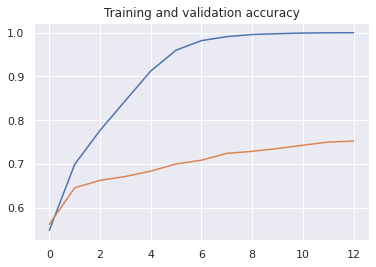

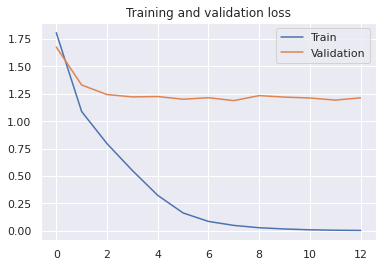

In [ ]:
plot_res(history_8_1)

## $\ell_1, \ell_2, \max$ регуляризація

### $\ell_1$

In [ ]:
model_9_1 = tf.keras.Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(64, 64, 1)),
  layers.Flatten(),
  layers.Dense(64*64, kernel_initializer="glorot_normal", activation="tanh", kernel_regularizer=regularizers.l1(0.001)),
  layers.Dropout(0.1),
  layers.BatchNormalization(),
  layers.Dense(64*64, kernel_initializer="glorot_normal", activation=layers.PReLU()),
  layers.Dense(64*64, kernel_initializer="glorot_normal", activation="relu"),
  layers.BatchNormalization(),
  layers.Dense(num_classes, kernel_initializer='glorot_normal', activation='softmax')
])

In [ ]:
model_9_1.compile(
  optimizer = tf.keras.optimizers.Adam(0.0005),
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [ ]:
with tf.device('/device:GPU:0'):
  history_9_1 = model_9_1.fit(
    train_generator,
    validation_data=valid_generator,
    epochs = 20,
    callbacks=[callback],
  )

Epoch 1/20
113/113 [==============================] - 157s 1s/step - loss: 112.4760 - accuracy: 0.4478 - val_loss: 8.9929 - val_accuracy: 0.0887
Epoch 2/20
113/113 [==============================] - 158s 1s/step - loss: 6.7662 - accuracy: 0.5170 - val_loss: 7.9004 - val_accuracy: 0.1158
Epoch 3/20
113/113 [==============================] - 156s 1s/step - loss: 5.9831 - accuracy: 0.5521 - val_loss: 7.0127 - val_accuracy: 0.2734
Epoch 4/20
113/113 [==============================] - 153s 1s/step - loss: 5.5967 - accuracy: 0.5848 - val_loss: 6.1945 - val_accuracy: 0.4416
Epoch 5/20
113/113 [==============================] - 139s 1s/step - loss: 5.3638 - accuracy: 0.6141 - val_loss: 5.6392 - val_accuracy: 0.5154
Epoch 6/20
113/113 [==============================] - 130s 1s/step - loss: 5.1441 - accuracy: 0.6442 - val_loss: 5.7479 - val_accuracy: 0.4965
Epoch 7/20
113/113 [==============================] - 134s 1s/step - loss: 4.9941 - accuracy: 0.6722 - val_loss: 5.4963 - val_accuracy: 0.55

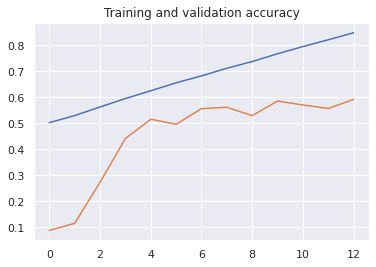

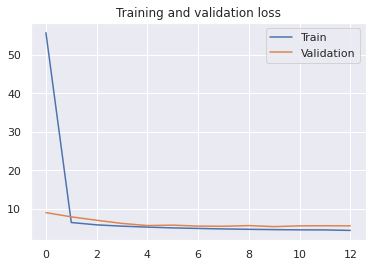

In [ ]:
plot_res(history_9_1)

### $\ell_2$

In [ ]:
model_9_2 = tf.keras.Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(64, 64, 1)),
  layers.Flatten(),
  layers.Dense(64*64, kernel_initializer="glorot_normal", activation="tanh", kernel_regularizer=regularizers.l2(0.01)),
  layers.BatchNormalization(),
  layers.Dense(64*64, kernel_initializer="glorot_normal", activation=layers.PReLU()),
  layers.Dropout(0.1),
  layers.Dense(64*64, kernel_initializer="glorot_normal", activation="relu"),
  layers.BatchNormalization(),
  layers.Dense(num_classes, kernel_initializer='glorot_normal', activation='softmax')
])

In [ ]:
model_9_2.compile(
  optimizer = tf.keras.optimizers.Adam(0.0005),
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [ ]:
with tf.device('/device:GPU:0'):
  history_9_2 = model_9_2.fit(
    train_generator,
    validation_data=valid_generator,
    epochs = 20,
    callbacks=[callback],
  )

Epoch 1/20
113/113 [==============================] - 114s 979ms/step - loss: 25.9292 - accuracy: 0.4480 - val_loss: 3.3833 - val_accuracy: 0.4070
Epoch 2/20
113/113 [==============================] - 111s 936ms/step - loss: 2.0526 - accuracy: 0.6104 - val_loss: 2.3575 - val_accuracy: 0.4998
Epoch 3/20
113/113 [==============================] - 113s 959ms/step - loss: 1.6600 - accuracy: 0.6497 - val_loss: 1.9630 - val_accuracy: 0.5741
Epoch 4/20
113/113 [==============================] - 112s 953ms/step - loss: 1.5310 - accuracy: 0.6810 - val_loss: 1.8062 - val_accuracy: 0.6139
Epoch 5/20
113/113 [==============================] - 112s 947ms/step - loss: 1.4399 - accuracy: 0.7039 - val_loss: 1.8317 - val_accuracy: 0.6144
Epoch 6/20
113/113 [==============================] - 111s 940ms/step - loss: 1.3636 - accuracy: 0.7260 - val_loss: 1.9536 - val_accuracy: 0.5955
Epoch 7/20
113/113 [==============================] - 109s 923ms/step - loss: 1.3012 - accuracy: 0.7437 - val_loss: 1.7750 

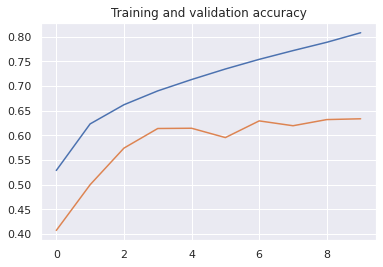

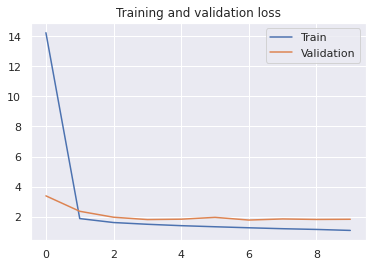

In [ ]:
plot_res(history_9_2)

### $\max$

In [ ]:
model_9_max = tf.keras.Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(64, 64, 1)),
  layers.Flatten(),
  layers.Dense(64*64, kernel_initializer="glorot_normal", activation="tanh", kernel_constraint=constraints.MaxNorm()),
  layers.BatchNormalization(),
  layers.Dense(64*64, kernel_initializer="glorot_normal", activation=layers.PReLU()),
  layers.Dropout(0.1),
  layers.Dense(64*64, kernel_initializer="glorot_normal", activation="relu"),
  layers.BatchNormalization(),
  layers.Dense(num_classes, kernel_initializer='glorot_normal', activation='softmax')
])

In [ ]:
model_9_max.compile(
  optimizer = tf.keras.optimizers.Adam(0.0005),
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [ ]:
with tf.device('/device:GPU:0'):
  history_9_max = model_9_max.fit(
    train_generator,
    validation_data=valid_generator,
    epochs = 20,
    callbacks=[callback],
  )

Epoch 1/20
113/113 [==============================] - 109s 909ms/step - loss: 2.4613 - accuracy: 0.4581 - val_loss: 1.6825 - val_accuracy: 0.5567
Epoch 2/20
113/113 [==============================] - 102s 862ms/step - loss: 1.1361 - accuracy: 0.6864 - val_loss: 1.3338 - val_accuracy: 0.6400
Epoch 3/20
113/113 [==============================] - 104s 884ms/step - loss: 0.8285 - accuracy: 0.7661 - val_loss: 1.2460 - val_accuracy: 0.6667
Epoch 4/20
113/113 [==============================] - 98s 826ms/step - loss: 0.5800 - accuracy: 0.8348 - val_loss: 1.2255 - val_accuracy: 0.6734
Epoch 5/20
113/113 [==============================] - 104s 880ms/step - loss: 0.3618 - accuracy: 0.9004 - val_loss: 1.1914 - val_accuracy: 0.6887
Epoch 6/20
113/113 [==============================] - 102s 861ms/step - loss: 0.1857 - accuracy: 0.9552 - val_loss: 1.1527 - val_accuracy: 0.7068
Epoch 7/20
113/113 [==============================] - 105s 886ms/step - loss: 0.0882 - accuracy: 0.9814 - val_loss: 1.1731 - 

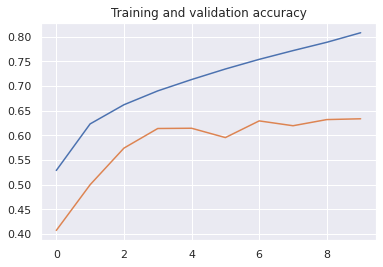

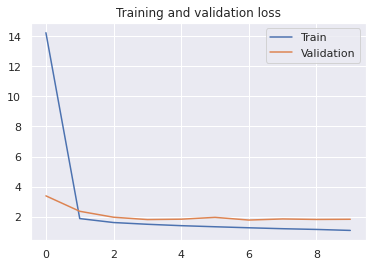

In [ ]:
plot_res(history_9_2)

## Інші моделі

In [ ]:
model_10 = tf.keras.Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(64, 64, 1)),
  layers.Flatten(),
  layers.Dense(64*64, kernel_initializer="glorot_normal", activation="tanh", kernel_constraint=constraints.MaxNorm()),
  layers.BatchNormalization(),
  layers.Dense(64*64, kernel_initializer="glorot_normal", activation=layers.PReLU()),
  layers.BatchNormalization(),
  layers.Dense(64*64, kernel_initializer="glorot_normal", activation="relu", kernel_constraint=constraints.MaxNorm()),
  layers.Dropout(0.1),
  layers.Dense(num_classes, kernel_initializer='glorot_normal', activation='softmax')
])

In [ ]:
model_10.compile(
  optimizer = tf.keras.optimizers.Adam(0.0005),
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [ ]:
with tf.device('/device:GPU:0'):
  history_10 = model_10.fit(
    train_generator,
    validation_data=valid_generator,
    epochs = 20,
    callbacks=[callback],
  )

Epoch 1/20
113/113 [==============================] - 95s 793ms/step - loss: 2.5097 - accuracy: 0.4508 - val_loss: 1.6333 - val_accuracy: 0.5533
Epoch 2/20
113/113 [==============================] - 91s 774ms/step - loss: 1.1444 - accuracy: 0.6865 - val_loss: 1.3071 - val_accuracy: 0.6476
Epoch 3/20
113/113 [==============================] - 87s 737ms/step - loss: 0.7505 - accuracy: 0.7851 - val_loss: 1.3226 - val_accuracy: 0.6706
Epoch 4/20
113/113 [==============================] - 89s 758ms/step - loss: 0.4479 - accuracy: 0.8680 - val_loss: 1.3559 - val_accuracy: 0.6820
Epoch 5/20
113/113 [==============================] - 86s 726ms/step - loss: 0.2298 - accuracy: 0.9347 - val_loss: 1.3033 - val_accuracy: 0.7027
Epoch 6/20
113/113 [==============================] - 88s 753ms/step - loss: 0.1123 - accuracy: 0.9699 - val_loss: 1.3567 - val_accuracy: 0.7138
Epoch 7/20
113/113 [==============================] - 86s 737ms/step - loss: 0.0663 - accuracy: 0.9827 - val_loss: 1.4034 - val_ac

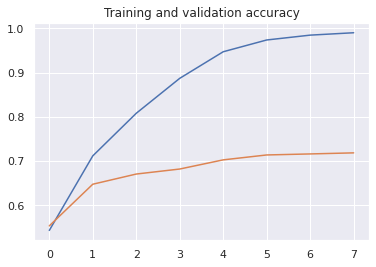

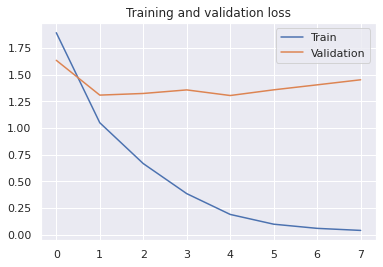

In [ ]:
plot_res(history_10)

## Навчання вихідних даних (повний набір класів)

### Рання зупинка і дропаут

In [ ]:
train_full, valid_full = generate_train_valid(500, "/tmp/kkanji2",'categorical', image_classes)

In [ ]:
model_full_1 = tf.keras.Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(64, 64, 1)),
  layers.Flatten(),
  layers.Dense(64*64, kernel_initializer="glorot_normal", activation="tanh"),
  layers.BatchNormalization(),
  layers.Dense(64*64, kernel_initializer="glorot_normal", activation=layers.PReLU()),
  layers.Dropout(0.1),
  layers.Dense(64*64, kernel_initializer="glorot_normal", activation="relu"),
  layers.BatchNormalization(),
  layers.Dense(len(image_classes), kernel_initializer='glorot_normal', activation='softmax')
])

In [ ]:
model_full_1.compile(
  optimizer = tf.keras.optimizers.Adam(0.0005),
  loss='categorical_crossentropy',
  metrics=['accuracy'])

In [ ]:
with tf.device('/device:GPU:0'):
  history_full_1 = model_full_1.fit(
    train_full,
    validation_data=valid_full,
    epochs = 20,
    callbacks=[callback],
  )

Epoch 1/20
225/225 [==============================] - 98s 425ms/step - loss: 3.7708 - accuracy: 0.4303 - val_loss: 2.2295 - val_accuracy: 0.5927
Epoch 2/20
225/225 [==============================] - 98s 427ms/step - loss: 1.3599 - accuracy: 0.7215 - val_loss: 1.8640 - val_accuracy: 0.6544
Epoch 3/20
225/225 [==============================] - 98s 428ms/step - loss: 0.5583 - accuracy: 0.8763 - val_loss: 1.6063 - val_accuracy: 0.7002
Epoch 4/20
225/225 [==============================] - 98s 430ms/step - loss: 0.1765 - accuracy: 0.9640 - val_loss: 1.4789 - val_accuracy: 0.7292
Epoch 5/20
225/225 [==============================] - 98s 431ms/step - loss: 0.0553 - accuracy: 0.9912 - val_loss: 1.3979 - val_accuracy: 0.7491
Epoch 6/20
225/225 [==============================] - 98s 431ms/step - loss: 0.0302 - accuracy: 0.9952 - val_loss: 1.3974 - val_accuracy: 0.7533
Epoch 7/20
225/225 [==============================] - 99s 432ms/step - loss: 0.0192 - accuracy: 0.9972 - val_loss: 1.4037 - val_ac

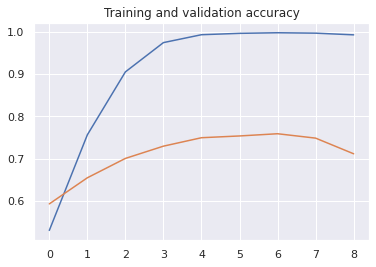

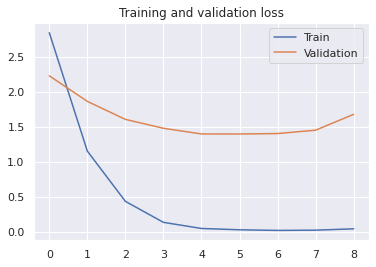

In [ ]:
plot_res(history_full_1)

### З $\max$ регуляризацією

In [ ]:
model_full_max = tf.keras.Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(64, 64, 1)),
  layers.Flatten(),
  layers.Dense(64*64, kernel_initializer="glorot_normal", activation="tanh", kernel_constraint=constraints.MaxNorm()),
  layers.BatchNormalization(),
  layers.Dense(64*64, kernel_initializer="glorot_normal", activation=layers.PReLU()),
  layers.Dropout(0.1),
  layers.Dense(64*64, kernel_initializer="glorot_normal", activation="relu"),
  layers.BatchNormalization(),
  layers.Dropout(0.1),
  layers.Dense(len(image_classes), kernel_initializer='glorot_normal', activation='softmax')
])

In [ ]:
model_full_max.compile(
  optimizer = tf.keras.optimizers.Adam(0.0005),
  loss='categorical_crossentropy',
  metrics=['accuracy'])

In [ ]:
with tf.device('/device:GPU:0'):
  history_full_max = model_full_max.fit(
    train_full,
    validation_data=valid_full,
    epochs = 20,
    callbacks=[callback],
  )

Epoch 1/20
225/225 [==============================] - 108s 469ms/step - loss: 3.8373 - accuracy: 0.4243 - val_loss: 2.2832 - val_accuracy: 0.5827
Epoch 2/20
225/225 [==============================] - 100s 438ms/step - loss: 1.4499 - accuracy: 0.7106 - val_loss: 1.8364 - val_accuracy: 0.6621
Epoch 3/20
225/225 [==============================] - 106s 466ms/step - loss: 0.6548 - accuracy: 0.8531 - val_loss: 1.6398 - val_accuracy: 0.6946
Epoch 4/20
225/225 [==============================] - 103s 452ms/step - loss: 0.2276 - accuracy: 0.9520 - val_loss: 1.4780 - val_accuracy: 0.7284
Epoch 5/20
225/225 [==============================] - 102s 447ms/step - loss: 0.0742 - accuracy: 0.9868 - val_loss: 1.4273 - val_accuracy: 0.7444
Epoch 6/20
225/225 [==============================] - 103s 452ms/step - loss: 0.0401 - accuracy: 0.9935 - val_loss: 1.3844 - val_accuracy: 0.7548
Epoch 7/20
225/225 [==============================] - 111s 486ms/step - loss: 0.0245 - accuracy: 0.9962 - val_loss: 1.4162 -

### Більше дропаутів

In [ ]:
model_full_dropout = tf.keras.Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(64, 64, 1)),
  layers.Flatten(),
  layers.Dense(64*64, kernel_initializer="glorot_normal", activation="tanh"),
  layers.Dropout(0.1),
  layers.Dense(64*64, kernel_initializer="glorot_normal", activation=layers.PReLU()),
  layers.Dropout(0.1),
  layers.Dense(64*64, kernel_initializer="glorot_normal", activation="relu"),
  layers.BatchNormalization(),
  layers.Dropout(0.1),
  layers.Dense(len(image_classes), kernel_initializer='glorot_normal', activation='softmax')
])
  
 

In [ ]:
train_full, valid_full = generate_train_valid(500, "/tmp/kkanji2",'categorical', image_classes)

Found 140424 files belonging to 3832 classes.
Using 112340 files for training.
Found 140424 files belonging to 3832 classes.
Using 28084 files for validation.


In [ ]:
model_full_dropout.compile(
  optimizer = tf.keras.optimizers.Adam(0.0005),
  loss='categorical_crossentropy',
  metrics=['accuracy', tf.keras.metrics.AUC()])

In [ ]:
with tf.device('/device:GPU:0'):
  history_full_dropout = model_full_dropout.fit(
      train_full,
      validation_data=valid_full,
      epochs = 20,
      callbacks=[callback],
    )

Epoch 1/20
225/225 [==============================] - 126s 549ms/step - loss: 4.1963 - accuracy: 0.3734 - auc_1: 0.8023 - val_loss: 2.4747 - val_accuracy: 0.5518 - val_auc_1: 0.9093
Epoch 2/20
225/225 [==============================] - 123s 540ms/step - loss: 1.7930 - accuracy: 0.6542 - auc_1: 0.9440 - val_loss: 1.8381 - val_accuracy: 0.6575 - val_auc_1: 0.9396
Epoch 3/20
225/225 [==============================] - 122s 539ms/step - loss: 0.9334 - accuracy: 0.7924 - auc_1: 0.9821 - val_loss: 1.6100 - val_accuracy: 0.6984 - val_auc_1: 0.9475
Epoch 4/20
225/225 [==============================] - 114s 502ms/step - loss: 0.3952 - accuracy: 0.9102 - auc_1: 0.9961 - val_loss: 1.5285 - val_accuracy: 0.7184 - val_auc_1: 0.9483
Epoch 5/20
225/225 [==============================] - 116s 512ms/step - loss: 0.1445 - accuracy: 0.9700 - auc_1: 0.9994 - val_loss: 1.4731 - val_accuracy: 0.7360 - val_auc_1: 0.9501
Epoch 6/20
225/225 [==============================] - 116s 511ms/step - loss: 0.0651 - acc

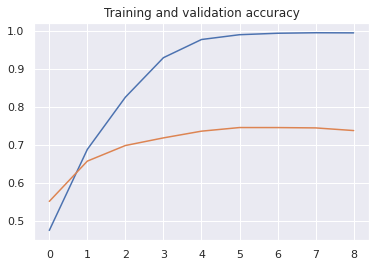

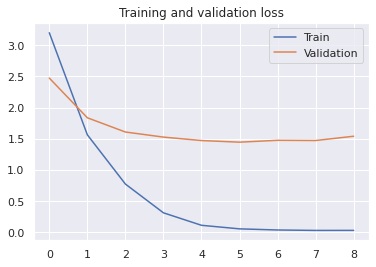

In [ ]:
plot_res(history_full_dropout)

In [ ]:
model_full_batch = tf.keras.Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(64, 64, 1)),
  layers.Flatten(),
  layers.Dense(64*64, kernel_initializer="glorot_normal", activation="tanh", kernel_constraint=constraints.MaxNorm()),
  layers.BatchNormalization(),
  layers.Dropout(0.1),
  layers.Dense(64*64, kernel_initializer="glorot_normal", activation=layers.PReLU(), kernel_constraint=constraints.MaxNorm()),
  layers.BatchNormalization(),
  layers.Dropout(0.1),
  layers.Dense(64*64, kernel_initializer="glorot_normal", activation="relu", kernel_constraint=constraints.MaxNorm()),
  layers.BatchNormalization(),
  layers.Dropout(0.1),
  layers.Dense(len(image_classes), kernel_initializer='glorot_normal', activation='softmax')
])

In [ ]:
model_full_batch.compile(
  optimizer = tf.keras.optimizers.Adam(0.0005),
  loss='categorical_crossentropy',
  metrics=['accuracy', tf.keras.metrics.AUC()])

In [ ]:
with tf.device('/device:GPU:0'):
  history_full_batch = model_full_batch.fit(
      train_full,
      validation_data=valid_full,
      epochs = 20,
      callbacks=[callback],
    )

Epoch 1/20
225/225 [==============================] - 129s 562ms/step - loss: 3.8232 - accuracy: 0.4264 - auc_2: 0.8259 - val_loss: 2.1642 - val_accuracy: 0.6110 - val_auc_2: 0.9217
Epoch 2/20
225/225 [==============================] - 129s 567ms/step - loss: 1.3532 - accuracy: 0.7221 - auc_2: 0.9615 - val_loss: 1.8060 - val_accuracy: 0.6677 - val_auc_2: 0.9384
Epoch 3/20
225/225 [==============================] - 129s 571ms/step - loss: 0.5573 - accuracy: 0.8701 - auc_2: 0.9920 - val_loss: 1.6734 - val_accuracy: 0.6907 - val_auc_2: 0.9445
Epoch 4/20
225/225 [==============================] - 129s 571ms/step - loss: 0.1751 - accuracy: 0.9606 - auc_2: 0.9988 - val_loss: 1.4939 - val_accuracy: 0.7310 - val_auc_2: 0.9484
Epoch 5/20
225/225 [==============================] - 129s 569ms/step - loss: 0.0658 - accuracy: 0.9858 - auc_2: 0.9996 - val_loss: 1.4385 - val_accuracy: 0.7510 - val_auc_2: 0.9491
Epoch 6/20
225/225 [==============================] - 130s 571ms/step - loss: 0.0321 - acc

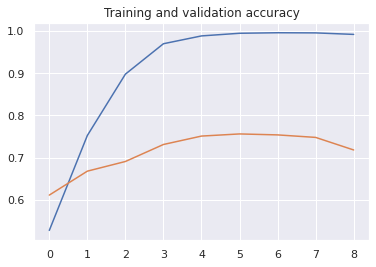

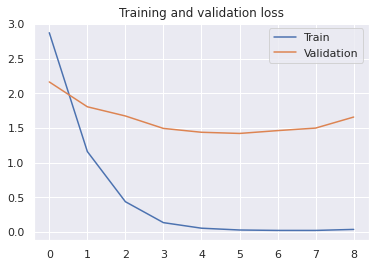

In [ ]:
plot_res(history_full_batch)

### Трохи вища ймовірність дропауту і рання зупинка на крок раніше



In [ ]:
model_high_dropout = tf.keras.Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(64, 64, 1)),
  layers.Flatten(),
  layers.Dense(64*64, kernel_initializer="glorot_normal", activation="relu", kernel_constraint=constraints.MaxNorm()),
  layers.BatchNormalization(),
  layers.Dropout(0.2),
  layers.Dense(64*64, kernel_initializer="glorot_normal", activation=layers.PReLU(), kernel_constraint=constraints.MaxNorm()),
  layers.BatchNormalization(),
  layers.Dropout(0.2),
  layers.Dense(64*64, kernel_initializer="glorot_normal", activation="relu", kernel_constraint=constraints.MaxNorm()),
  layers.BatchNormalization(),
  layers.Dropout(0.2),
  layers.Dense(len(image_classes), kernel_initializer='glorot_normal', activation='softmax')
])

In [ ]:
model_high_dropout.compile(
  optimizer = tf.keras.optimizers.Adam(0.0005),
  loss='categorical_crossentropy',
  metrics=['accuracy', tf.keras.metrics.AUC()])

In [ ]:
with tf.device('/device:GPU:0'):
  history_high_dropout = model_high_dropout.fit(
      train_full,
      validation_data=valid_full,
      epochs = 20,
      callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)],
    )

Epoch 1/20
225/225 [==============================] - 134s 581ms/step - loss: 4.0746 - accuracy: 0.3974 - auc_3: 0.8093 - val_loss: 2.1070 - val_accuracy: 0.6149 - val_auc_3: 0.9281
Epoch 2/20
225/225 [==============================] - 133s 587ms/step - loss: 1.5515 - accuracy: 0.6908 - auc_3: 0.9525 - val_loss: 1.7988 - val_accuracy: 0.6671 - val_auc_3: 0.9375
Epoch 3/20
225/225 [==============================] - 133s 585ms/step - loss: 0.7986 - accuracy: 0.8124 - auc_3: 0.9851 - val_loss: 1.6882 - val_accuracy: 0.6903 - val_auc_3: 0.9418
Epoch 4/20
225/225 [==============================] - 133s 587ms/step - loss: 0.3671 - accuracy: 0.9079 - auc_3: 0.9962 - val_loss: 1.6117 - val_accuracy: 0.7118 - val_auc_3: 0.9434
Epoch 5/20
225/225 [==============================] - 133s 585ms/step - loss: 0.1748 - accuracy: 0.9544 - auc_3: 0.9991 - val_loss: 1.5351 - val_accuracy: 0.7355 - val_auc_3: 0.9460
Epoch 6/20
225/225 [==============================] - 132s 583ms/step - loss: 0.1031 - acc

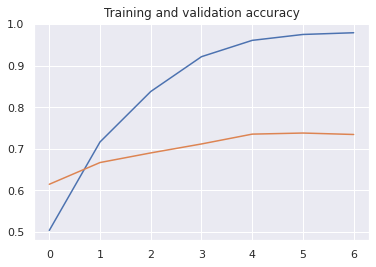

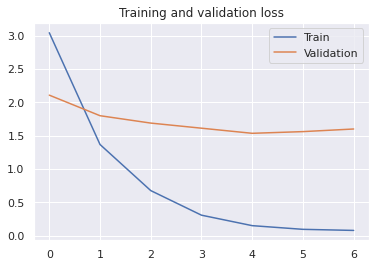

In [ ]:
plot_res(history_high_dropout)

### Додавання шару з гаусівським шумом

In [ ]:
model_gauss = tf.keras.Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(64, 64, 1)),
  layers.Flatten(),
  layers.GaussianNoise(0.2),
  layers.Dense(64*64, kernel_initializer="glorot_normal", activation="relu", kernel_constraint=constraints.MaxNorm()),
  layers.BatchNormalization(),
  layers.Dropout(0.5),
  layers.Dense(64*64, kernel_initializer="glorot_normal", activation=layers.PReLU(), kernel_constraint=constraints.MaxNorm()),
  layers.BatchNormalization(),
  layers.Dropout(0.1),
  layers.Dense(64*64, kernel_initializer="glorot_normal", activation="relu", kernel_constraint=constraints.MaxNorm()),
  layers.BatchNormalization(),
  layers.Dropout(0.1),
  layers.Dense(len(image_classes), kernel_initializer='glorot_normal', activation='softmax')
])

In [ ]:
model_gauss.compile(
  optimizer = tf.keras.optimizers.Adam(0.0005),
  loss='categorical_crossentropy',
  metrics=['accuracy', tf.keras.metrics.AUC()])

In [ ]:
with tf.device('/device:GPU:0'):
  history_gauss = model_gauss.fit(
      train_full,
      validation_data=valid_full,
      epochs = 20,
      callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)],
    )

Epoch 1/20
225/225 [==============================] - 129s 564ms/step - loss: 4.3521 - accuracy: 0.3603 - auc_5: 0.7921 - val_loss: 2.2068 - val_accuracy: 0.6036 - val_auc_5: 0.9209
Epoch 2/20
225/225 [==============================] - 129s 567ms/step - loss: 1.7988 - accuracy: 0.6452 - auc_5: 0.9422 - val_loss: 1.8438 - val_accuracy: 0.6720 - val_auc_5: 0.9344
Epoch 3/20
225/225 [==============================] - 129s 568ms/step - loss: 1.0804 - accuracy: 0.7562 - auc_5: 0.9752 - val_loss: 1.6439 - val_accuracy: 0.7100 - val_auc_5: 0.9433
Epoch 4/20
225/225 [==============================] - 129s 567ms/step - loss: 0.6153 - accuracy: 0.8488 - auc_5: 0.9906 - val_loss: 1.5650 - val_accuracy: 0.7268 - val_auc_5: 0.9453
Epoch 5/20
225/225 [==============================] - 129s 571ms/step - loss: 0.3506 - accuracy: 0.9091 - auc_5: 0.9967 - val_loss: 1.5232 - val_accuracy: 0.7418 - val_auc_5: 0.9468
Epoch 6/20
225/225 [==============================] - 129s 567ms/step - loss: 0.2039 - acc

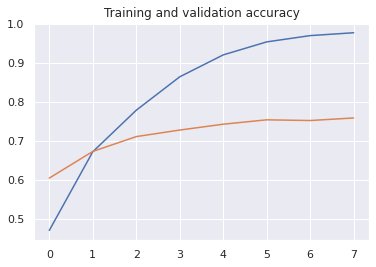

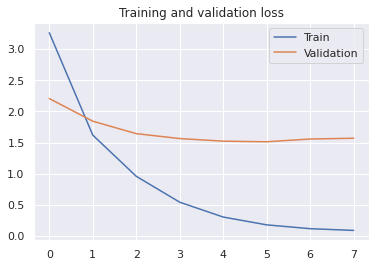

In [ ]:
plot_res(history_gauss)

### Adadelta

In [ ]:
model_adadelta = tf.keras.Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(64, 64, 1)),
  layers.Flatten(),
  layers.GaussianNoise(0.2),
  layers.Dense(64*64, kernel_initializer="glorot_normal", activation="relu", kernel_constraint=constraints.MaxNorm()),
  layers.BatchNormalization(),
  layers.Dropout(0.5),
  layers.Dense(64*64, kernel_initializer="glorot_normal", activation=layers.PReLU(), kernel_constraint=constraints.MaxNorm()),
  layers.BatchNormalization(),
  layers.Dropout(0.1),
  layers.Dense(64*64, kernel_initializer="glorot_normal", activation="relu", kernel_constraint=constraints.MaxNorm()),
  layers.BatchNormalization(),
  layers.Dropout(0.1),
  layers.Dense(len(image_classes), kernel_initializer='glorot_normal', activation='softmax')
])

In [ ]:
model_adadelta.compile(
  optimizer = tf.keras.optimizers.Adadelta(),
  loss='categorical_crossentropy',
  metrics=['accuracy', tf.keras.metrics.AUC()])

In [ ]:
with tf.device('/device:GPU:0'):
  history_adadelta = model_adadelta.fit(
      train_full,
      validation_data=valid_full,
      epochs = 20,
      callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)],
    )

Epoch 1/20
225/225 [==============================] - 130s 569ms/step - loss: 8.7710 - accuracy: 5.7038e-04 - auc_6: 0.5002 - val_loss: 8.2524 - val_accuracy: 0.0013 - val_auc_6: 0.5000
Epoch 2/20
225/225 [==============================] - 130s 572ms/step - loss: 8.5655 - accuracy: 0.0033 - auc_6: 0.5023 - val_loss: 8.0455 - val_accuracy: 0.0345 - val_auc_6: 0.5092
Epoch 3/20
225/225 [==============================] - 130s 573ms/step - loss: 8.3476 - accuracy: 0.0186 - auc_6: 0.5112 - val_loss: 7.7981 - val_accuracy: 0.0710 - val_auc_6: 0.5212
Epoch 4/20
225/225 [==============================] - 130s 575ms/step - loss: 8.1369 - accuracy: 0.0335 - auc_6: 0.5201 - val_loss: 7.5811 - val_accuracy: 0.0970 - val_auc_6: 0.5377
Epoch 5/20
225/225 [==============================] - 130s 575ms/step - loss: 7.9363 - accuracy: 0.0531 - auc_6: 0.5324 - val_loss: 7.3780 - val_accuracy: 0.1162 - val_auc_6: 0.5529
Epoch 6/20
225/225 [==============================] - 130s 574ms/step - loss: 7.7421 -

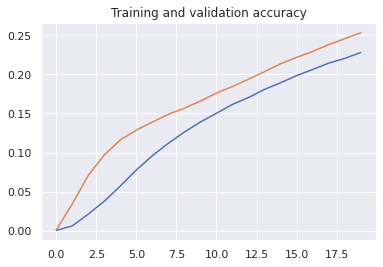

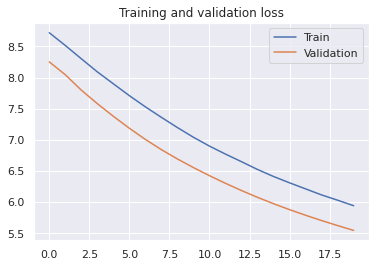

In [ ]:
plot_res(history_adadelta)

## Найкраща модель

З додавання шару з гауссівським шумом

### Передбачення

In [ ]:
img_to_pred = '/tmp/kkanji2/U+6597/40a0085dccede622.png'
img = load_img(img_to_pred, target_size=(64, 64), color_mode="grayscale") 
x = img_to_array(img)
x = x.reshape((1,) + x.shape)
x /= 255

In [ ]:
pred = model_gauss.predict(x)
print(image_classes[np.argmax(pred)])

U+6597
